In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product

In [20]:
# fetch FRED data
def fetch_fred_data(api_key, series_id):
    fred = Fred(api_key=api_key)
    data = fred.get_series(series_id)
    df = pd.DataFrame({'date': data.index, 'value': data.values})
    return df

# Fetch ICNSA data using FRED API
FRED_API_KEY = '360481124fc765b815de2697f1bf8d62'
icnsa = fetch_fred_data(api_key=FRED_API_KEY, series_id='ICNSA')

In [21]:
# Converting 'value' column to numeric
icnsa['value'] = pd.to_numeric(icnsa['value'], errors='coerce')

In [22]:
# Checking missing values
missing_values = icnsa['value'].isnull().any()
print("Missing Values:", missing_values)

Missing Values: False


In [23]:
# Handling extreme values during COVID years using winsorization
covid_threshold = np.nanquantile(icnsa['value'], 0.99)
icnsa['value'] = np.clip(icnsa['value'], a_min=None, a_max=covid_threshold)


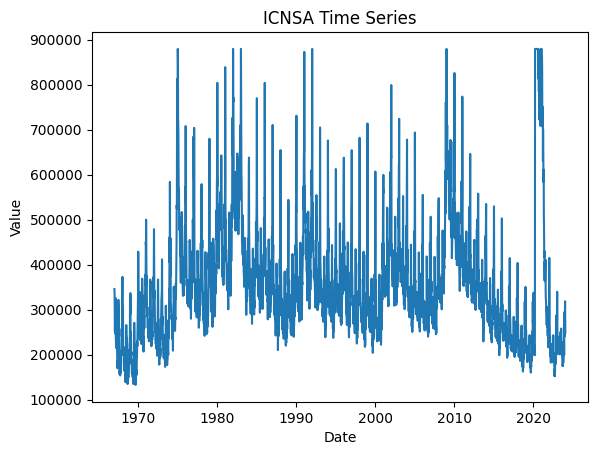

In [25]:
# Time series plot
plt.plot(icnsa['date'], icnsa['value'])
plt.title("ICNSA Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

In [26]:
# Grid search for SARIMAX parameters
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

In [33]:
# Generate all possible combinations of p, d, q
orders = list(product(p_values, d_values, q_values))

# Finding optimal parameters using grid search
best_bic = np.inf
best_order = None

for order in orders:
    try:
        arima_model = SARIMAX(icnsa['value'], order=order)
        arima_results = arima_model.fit(disp=False)
        bic = arima_results.bic
        if bic < best_bic:
            best_bic = bic
            best_order = order
    except:
        continue

print("Best SARIMAX Order:", best_order)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

Best SARIMAX Order: (2, 1, 2)


In [34]:
# Fit ARIMA model with the best parameters
arima_model_best = SARIMAX(icnsa['value'], order=best_order)
arima_results_best = arima_model_best.fit(disp=False)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
# Forecast without seasonal adjustment
forecast_arima = arima_results_best.get_forecast(steps=1)
predicted_value = round(forecast_arima.predicted_mean.values[0])
print("Forecast value:", predicted_value)

Forecast value: 252358


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


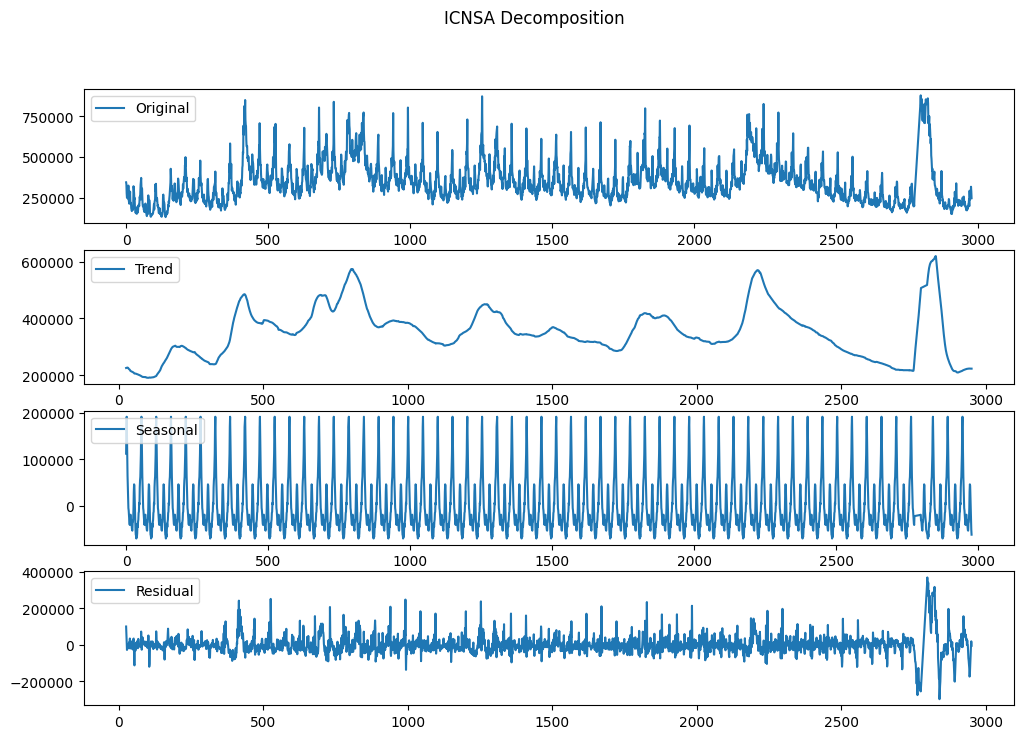

In [36]:
# Time series decomposition
result = seasonal_decompose(icnsa['value'], model='additive', period=52)

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(icnsa['value'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.suptitle('ICNSA Decomposition')
plt.show()

In [37]:
# Check for seasonality pattern
seasonal_pattern = 52 
if seasonal_pattern > 1:
    # Applying seasonal adjustment
    seasonal_adj = result.seasonal
else:
    seasonal_adj = icnsa['value']

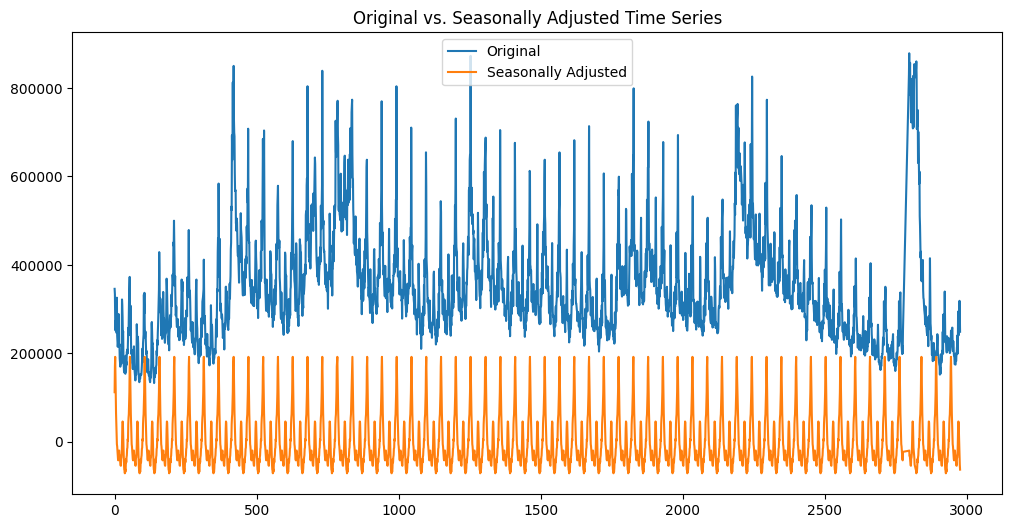

In [38]:
# Visualizing original and seasonally adjusted time series
plt.figure(figsize=(12, 6))
plt.plot(icnsa['value'], label='Original')
plt.plot(seasonal_adj, label='Seasonally Adjusted')
plt.title('Original vs. Seasonally Adjusted Time Series')
plt.legend()
plt.show()

In [40]:
# Fit ARIMA model with seasonality adjustment using the best parameters
arima_model_adj = SARIMAX(seasonal_adj, order=best_order)
arima_results_adj = arima_model_adj.fit(disp=False)
forecast_arima_adj = arima_results_adj.get_forecast(steps=1)
predicted_value_adj = round(forecast_arima_adj.predicted_mean.values[0])
print("Forecast value with seasonality adjustment:", predicted_value_adj)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecast value with seasonality adjustment: -67247


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [41]:
# Refit model on full data with best parameters
model = SARIMAX(icnsa['value'], order=best_params)
results = model.fit()

# Make forecast for future dates
future_dates = pd.date_range(start=icnsa['date'].max() + pd.DateOffset(days=1), periods=52, freq='D')
forecast = results.get_forecast(steps=52)
pred = forecast.predicted_mean

# Evaluate forecast RMSE
mse = mean_squared_error(test['value'], pred)
print('Test RMSE: %.3f' % np.sqrt(mse))

Test RMSE: 225783.146


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exc